In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 

import rayleigh
from scipy.stats import binned_statistic_2d

from astropy.io import fits as pyfits
from astropy.stats import funcs

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

Follow Tom Barclay's demo to read in data and make a quick/dirty light curve

In [2]:
file = 'k2-trappist1-unofficial-tpf-short-cadence.fits'

f = pyfits.open(file)
data = f[1].data

In [3]:
f[1].data['FLUX'].shape

(107968, 11, 11)

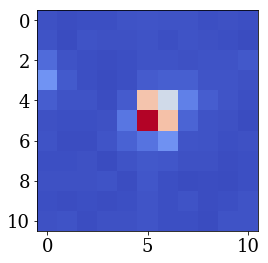

In [4]:
plt.imshow(np.sqrt(np.abs(f[1].data['FLUX'][0][:,:])), cmap='coolwarm', aspect='equal', interpolation='nearest')
plt.tight_layout()

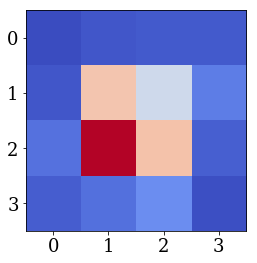

In [5]:
plt.imshow(np.sqrt(np.abs(f[1].data['FLUX'][0][3:7,4:8])), cmap='coolwarm', aspect='equal', interpolation='nearest')
plt.tight_layout()

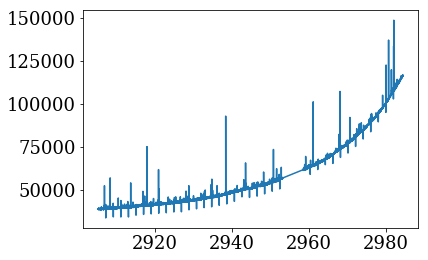

In [6]:
# The raw, total flux lightcurve of the entire postage stamp
plt.plot(f[1].data['TIME'], np.sum(f[1].data['FLUX'],axis=(1,2)))

Make a lightcurve using just the *center* of the postage stamp (hopefully just Trappist 1)

Then smooth it to take out long term trend, and clip low flux points (maybe some transits, probably a bunch of pointing adjustments)

In [7]:
fraw_pre = np.sum(f[1].data['FLUX'][:,3:7,4:8], axis=(1,2))

sky_pre1 = np.sum(f[1].data['FLUX'][:,0:2,4:8], axis=(1,2))
sky_pre2 = np.sum(f[1].data['FLUX'][:,9:,4:8], axis=(1,2))

time = f[1].data['TIME']
# fraw = np.sum(f[1].data['FLUX'],axis=(1,2))

fraw = fraw_pre - (sky_pre1 + sky_pre2)

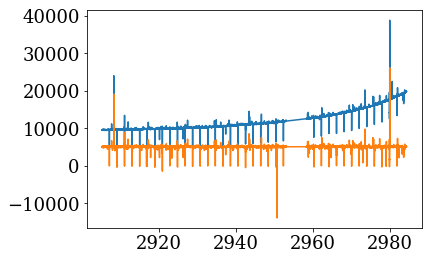

In [8]:
plt.plot(time, fraw_pre)
plt.plot(time, fraw)

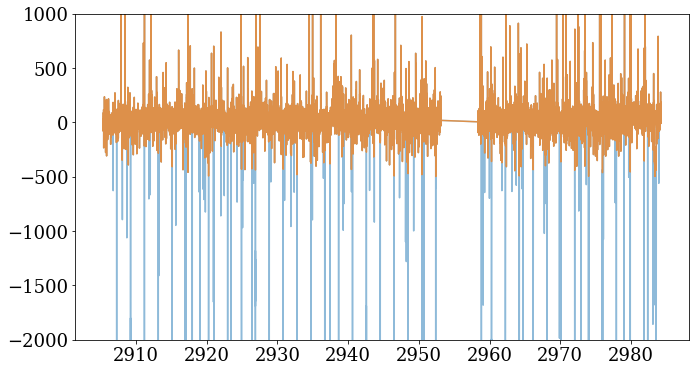

In [9]:
fit = np.polyfit(time, fraw, 4)
pp = np.poly1d(fit)

plt.figure(figsize=(11,6))
plt.plot(time, fraw - pp(time), alpha=0.5)
plt.ylim(-2000, 1000)

x = np.where((fraw - pp(time) > -500) & np.isreal(fraw) & np.isfinite(fraw))
plt.plot(time[x], fraw[x] - pp(time[x]), alpha=0.7)

(2979.8, 2980)

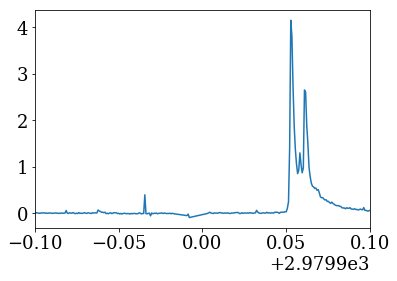

In [10]:
plt.plot(time[x], (fraw[x] - pp(time[x])) / np.median(fraw[x]))
plt.xlim(2979.8,2980)
# the flare that Tom Barclay found already (as of 730am, 2017-Mar-08)

Now smooth the light curve using rolling medians. Tried a couple, I like just using the coarse one (100 data point window)

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()


(2979.8, 2980)

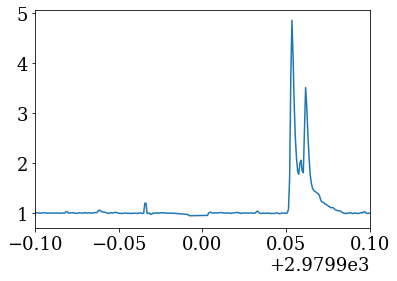

In [11]:
smo = pd.rolling_median(fraw[x], 100, center=True)

smo2 = pd.rolling_median(fraw[x] - smo, 2, center=True)

plt.plot(time[x], smo2 / np.median(fraw[x]) + 1)
plt.xlim(2979.8,2980)

We can see the rotational modulation in the short-term smoothed light curve. Cool.

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app


(0.975, 1.025)

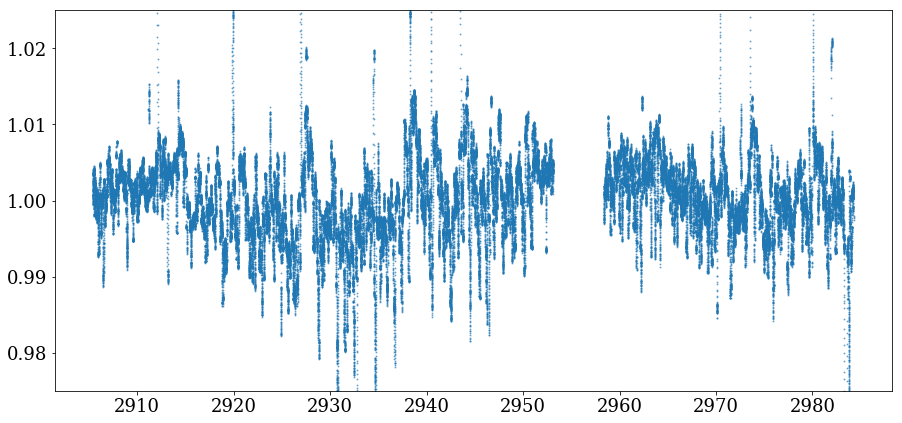

In [12]:
plt.figure(figsize=(15,7))
plt.scatter(time[x], pd.rolling_mean(fraw[x], 60, center=True)/np.median(fraw[x]), 
            alpha=0.5, s=1)
plt.ylim(0.975, 1.025)

Write the slightly cleaned up light curve to a file.

This will be analyzed using [FBEYE](https://github.com/jradavenport/FBEYE), the Flares-By-EYE toolkit I wrote in IDL years back!

I would prefer to get the flares automatically using [appaloosa](https://github.com/jradavenport/appaloosa), which also does artificial flare injection/recovery tests to determine completeness... but it's not working on my new laptop. Sad Face.

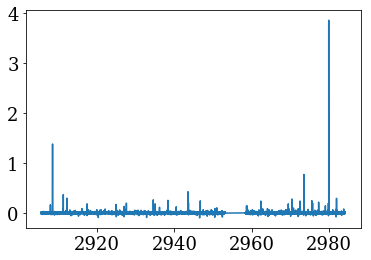

In [13]:
plt.plot(time[x], (smo2) / np.median(fraw[x]))

y = np.isfinite(smo2)
# dfout = pd.DataFrame(data={'time':time[x][y], 
#                            'flux':(fraw[x][y] - smo[y]) / np.median(fraw[x]),
#                           'error':np.zeros_like(time[y])})
# dfout.to_csv('trappist.csv', columns=('time', 'flux','error'), index=False)

Now that I've found some flares with FBEYE, read them back in!

In [14]:
names = ('Event_ID','Start_INDX','Stop_INDX','t_peak','t_start','t_stop','t_rise','t_decay',
         'Flux_peak','Equiv_Dur','S/N','CPLX_flg','MLTPK_flg','MLTPK_num','t_MLTPK','L_mltpk',
         'MLTPK_INDX','quies','x')
fbeye = pd.read_table('trappist.csv.fbeye', delim_whitespace=True, header=None, names = names, comment='#')
fbeye

,Event_ID,Start_INDX,Stop_INDX,t_peak,t_start,t_stop,t_rise,t_decay,Flux_peak,Equiv_Dur,S/N,CPLX_flg,MLTPK_flg,MLTPK_num,t_MLTPK,L_mltpk,MLTPK_INDX,quies,x
0,0,-99.0,-99.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000000000000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000000000000000,;
1,1,9828.0,9867.0,2912.118733,2912.117371,2912.143934,0.001362,0.025201,5.4162427269978100,-94159.462046,NaN,1.0,0.0,0.0,0.0,0.0,0.000000,-0.0005200440549820,;
2,2,10972.0,11002.0,2912.899297,2912.897253,2912.917687,0.002043,0.018390,7.5070804844197454,-19323.304946,NaN,1.0,0.0,0.0,0.0,0.0,0.000000,-0.0005201776737020,;
3,3,11065.0,11086.0,2912.974220,2912.960597,2912.974901,0.013623,0.000681,5.9912992544587862,-7704.467475,NaN,1.0,0.0,0.0,0.0,0.0,0.000000,-0.0005201331341290,;
4,4,15449.0,15467.0,2916.025638,2916.025638,2916.037898,0.000000,0.012260,19.8311842581343498,-44744.754768,NaN,1.0,0.0,0.0,0.0,0.0,0.000000,-0.0001733480183270,;
5,5,15844.0,15866.0,2916.294680,2916.294680,2916.309665,0.000000,0.014985,2.5066198604083327,-21578.134834,NaN,1.0,0.0,0.0,0.0,0.0,0.000000,-0.0003468741949470,;
6,6,21056.0,21119.0,2919.880777,2919.871923,2919.914833,0.008854,0.034056,16.2122956280480146,-75584.619438,NaN,1.0,0.0,0.0,0.0,0.0,0.000000,-0.0003466960366550,;
7,7,24259.0,24269.0,2922.077378,2922.075335,2922.082146,0.002043,0.004768,35.6700831175871684,5002.235563,61.161278,1.0,0.0,0.0,0.0,0.0,0.000000,0.0008668291707840,;
8,8,26723.0,26763.0,2923.757020,2923.757020,2923.784265,0.000000,0.027245,9.6945592325605752,-30584.747882,NaN,1.0,0.0,0.0,0.0,0.0,0.000000,-0.0004333700458190,;
9,9,31342.0,31416.0,2926.960328,2926.929677,2926.980080,0.030650,0.019753,10.1748785157141022,-83317.773046,NaN,1.0,0.0,0.0,0.0,0.0,0.000000,-0.0006068071432920,;


FBEYE has some bug in the calculation of Equivalent Duration, so redo that here.

Steps:
* define continuum regions on both sides of the flare (c1, c2)
* fit straight line and subtract to remove any starspot or instrumental signal
* compute trapezoidal sum of fractional brightness within the flare


In [15]:
t = time[x][y]
flux = (fraw[x][y] - smo[y]) / np.median(fraw[x])

ED = np.zeros(len(fbeye)-1)

# the first entry is null, skip it
for k in range(1,len(fbeye)):
    xfl = np.where((t >= fbeye['t_start'].values[k]) & (t <= fbeye['t_stop'].values[k]))

    c1 = np.where((t <= fbeye['t_start'].values[k]-5.0/24./60.) & (t >= fbeye['t_start'].values[k]-0.1))
    c2 = np.where((t >= fbeye['t_stop'].values[k]+10.0/24./60.) & (t <= fbeye['t_stop'].values[k]+0.1))
    
    slope = (np.median(flux[c1])-np.median(flux[c2]))/(np.median(t[c1])-np.median(t[c2]))
    inter = np.median(flux[c1]) - slope*np.median(t[c1])
    fit = [inter,slope]
    
    ED[k-1] = np.trapz(flux[xfl], t[xfl]*86400.)
    
    toff = np.floor(np.min(t[xfl]))
    toffs = str(2454833 + int(toff))
    
    plt.figure(figsize=(7,5))
    plt.plot(t - toff, flux)
    plt.xlabel('BJD - '+toffs+' (days)')
    plt.ylabel('Relative Flux')
    plt.ylim(np.min(flux[xfl]), np.max(flux[xfl]))
    plt.xlim(np.nanmin(t[xfl])-0.001 - toff, np.nanmax(t[xfl]+0.005 - toff))
    plt.savefig('flare_'+str(k)+'.png', dpi=150, bbox_inches='tight', pad_inches=0.25)
    plt.close()

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version


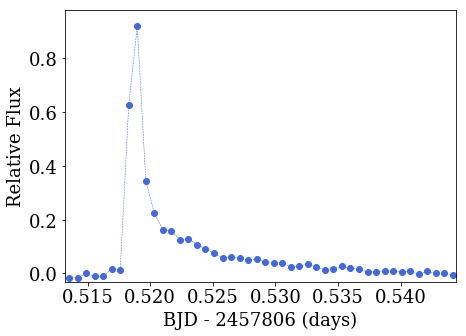

In [16]:
k = 29

xfl = np.where((t >= fbeye['t_start'].values[k]) & (t <= fbeye['t_stop'].values[k]))

c1 = np.where((t <= fbeye['t_start'].values[k]-5.0/24./60.) & (t >= fbeye['t_start'].values[k]-0.1))
c2 = np.where((t >= fbeye['t_stop'].values[k]+10.0/24./60.) & (t <= fbeye['t_stop'].values[k]+0.1))

slope = (np.median(flux[c1])-np.median(flux[c2]))/(np.median(t[c1])-np.median(t[c2]))
inter = np.median(flux[c1]) - slope*np.median(t[c1])
fit = [inter,slope]

ED[k-1] = np.trapz(flux[xfl], t[xfl]*86400.)

toff = np.floor(np.min(t[xfl]))
toffs = str(2454833 + int(toff))

plt.figure(figsize=(7,5))
plt.plot(t - toff, flux, linestyle='--', lw=0.5, c='RoyalBlue')
plt.errorbar(t - toff, flux, yerr=np.nanmean(pd.rolling_std(flux, 10)), marker='o', lw=0.5, linestyle='none', c='RoyalBlue')
plt.xlabel('BJD - '+toffs+' (days)')
plt.ylabel('Relative Flux')
plt.ylim(-.03, 0.98);
plt.xlim(np.nanmin(t[xfl])-0.001 - toff, np.nanmax(t[xfl]+0.005 - toff))
plt.savefig('flare_'+str(k)+'.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)


In [17]:
np.nanmedian(pd.rolling_std(flux, 10))

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':


0.0061917929049763168

The classic figure of merit for flare rates: the Flare Frequency Distribution (or FFD for short)

This presents the *cumulative* rate of flares at a given energy or higher

(array([ 3.33008019,  2.32588959,  2.03282392,  2.01450643,  1.9913568 ,
        1.93318732,  1.93258868,  1.85773531,  1.68949689,  1.68909129,
        1.67922248,  1.50589332,  1.3848555 ,  1.30293433,  1.24594633,
        1.23384318,  1.19970519,  1.19163573,  1.17936295,  1.14334573,
        1.1238764 ,  1.1120607 ,  1.04698738,  1.02163114,  1.00641377,
        0.97924973,  0.93394374,  0.87927325,  0.8256979 ,  0.82501379,
        0.76418095,  0.75212438,  0.58478914,  0.3296837 , -0.48223946]), array([ 0.01347242,  0.02694485,  0.04041727,  0.05388969,  0.06736212,
        0.08083454,  0.09430697,  0.10777939,  0.12125181,  0.13472424,
        0.14819666,  0.16166908,  0.17514151,  0.18861393,  0.20208635,
        0.21555878,  0.2290312 ,  0.24250363,  0.25597605,  0.26944847,
        0.2829209 ,  0.29639332,  0.30986574,  0.32333817,  0.33681059,
        0.35028301,  0.36375544,  0.37722786,  0.39070029,  0.40417271,
        0.41764513,  0.43111756,  0.44458998,  0.4580624 ,  0

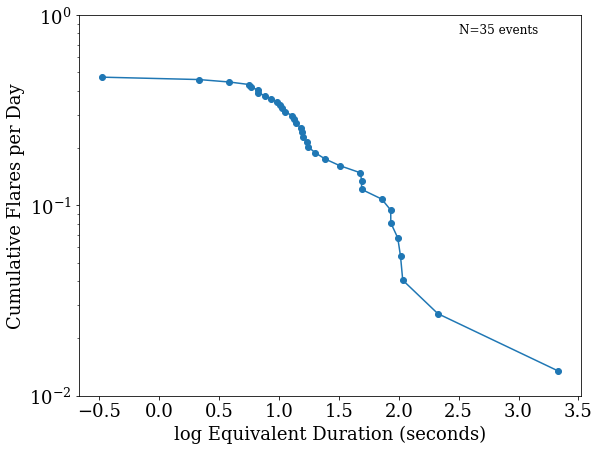

In [18]:
exptime = 1. / 24./60. # 1 min, in units of days
totdur = float(len(t)) * exptime

ss = np.argsort(ED)[::-1]

ffd_x = np.log10(ED[ss])
ffd_y = (np.arange(len(ffd_x)) + 1) / totdur


plt.figure(figsize=(9,7))
plt.plot(ffd_x, ffd_y, 'o-')
plt.yscale('log')
plt.ylim(1e-2,1e0)
plt.xlabel('log Equivalent Duration (seconds)')
plt.ylabel('Cumulative Flares per Day')

# plt.title('Flare Frequency from Trappist-1 with K2')
# plt.text(0.5, 1.2e-2, '@jradavenport', fontsize=12)
plt.text(2.5, 8e-1, 'N=35 events', fontsize=12)

plt.savefig('trappist_flares_ED.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

print(ffd_x, ffd_y)

Now I'll take an overly simplistic swing at converting the relative energy (Equiv Dur) to energy, by computing the quiescent luminosity of the star using the good-old-fashioned [blackbody luminosity](https://en.wikipedia.org/wiki/Luminosity#Luminosity_formula) we all learned as astronomy undergraduates!

NOTE: This is not very accurate, and doesn't take in to account:

* the luminosity *in the Kepler bandpass*
* the color or temperature of the flare event (typically about 10,000 K)
* the known distance of TRAPPIST-1

In [19]:
# way 1, blackbody (total Luminosity)
Teff = 2550.
sigma = 5.67051e-5
E_POINT = (4. * np.pi * (6.955e10 * 0.114)**2. * sigma * Teff**4.)


# way 2, compare to MOST-band luminosity for Proxima Cen, divide by 3 (from NLDS tbl 4.1)
L_m6_most = 10**28.69 # from Davenport et al. work on Proxima Cen
L_m8_m6 = L_m6_most / 3.


# way 3, scale from Sun (but again using total Lum)
# an independent calculation for New Light on Dark Stars (table 4.1)
L_sun = 3.826e33 # erg/s
L_m8 = 0.03e-2 * L_sun

print(E_POINT, L_m8, L_m8_m6)

(1.8940728451422425e+30, 1.1477999999999999e+30, 1.6325960645614922e+28)


In [20]:
# way 2 gives BEST estimate, since it's approx in the MOST bandpass, 
# and that in turn is close-ish to the Kepler bandpass... or close enough for messing about
E_POINT = L_m8_m6

print(E_POINT) # erg / s

1.63259606456e+28


[ -0.65493483  18.64005517]


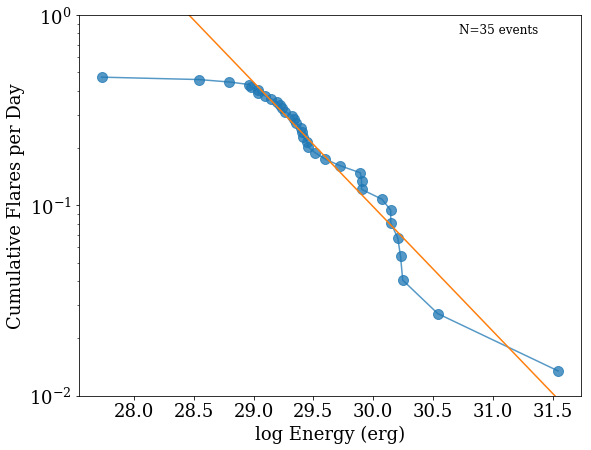

In [21]:
# fit a line to the Flare Freq Distribution
fitok = np.where((ffd_x + np.log10(E_POINT) > 29))

fit2 = np.polyfit(ffd_x[fitok] + np.log10(E_POINT), np.log10(ffd_y[fitok]), 1)
pp2 = np.poly1d(fit2)


plt.figure(figsize=(9,7))
plt.plot(ffd_x + np.log10(E_POINT), ffd_y, 'o-', markersize=10, alpha=0.75)

plt.plot(ffd_x + np.log10(E_POINT), 10.**pp2(ffd_x + np.log10(E_POINT)) )

plt.yscale('log')
plt.ylim(1e-2,1e0)
plt.xlabel('log Energy (erg)')
plt.ylabel('Cumulative Flares per Day')

# plt.title('Flare Frequency from Trappist-1 with K2')
# plt.text(0.5+ np.log10(E_POINT), 1.2e-2, '@jradavenport', fontsize=12)
plt.text(2.5+ np.log10(E_POINT), 8e-1, 'N=35 events', fontsize=12)

plt.savefig('trappist_flares.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

print(fit2)

In [22]:
df_out = pd.DataFrame(data={'logE':ffd_x + np.log10(E_POINT), 'logED':ffd_x, 'logFreq':ffd_y})
df_out.to_csv('trappist_k2_roughFFD.csv')

In [23]:
print('A 1e33 erg superflare every ' + str(1. / (10.**pp2(33.) * 365.)) + ' years')

A 1e33 erg superflare every 2.57336419985 years


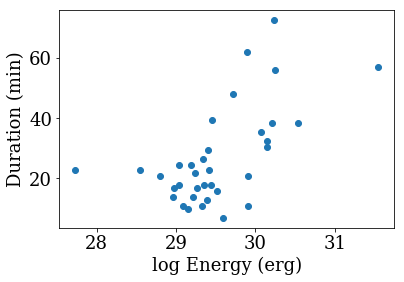

In [24]:
plt.scatter(np.log10(ED*E_POINT) , (fbeye['t_stop'].values[1:] - fbeye['t_start'].values[1:])*24.*60.)
plt.xlabel('log Energy (erg)')
plt.ylabel('Duration (min)')
# plt.title('Trappist-1 with K2')
# plt.xlim(27.4,32.1)
# plt.text(30.4, 10, '@jradavenport', fontsize=12)
plt.savefig('E_vs_Dur.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()


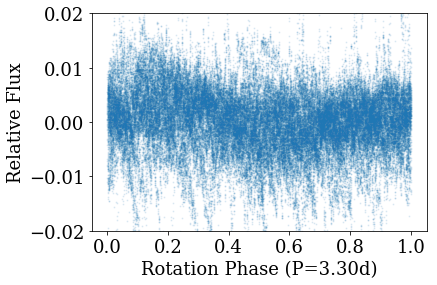

In [25]:
p_rot = 3.30

plt.scatter(np.mod(time[x], p_rot)/p_rot, pd.rolling_mean(fraw[x], 10, center=True)/np.median(fraw)-1, s=1, alpha=0.1)
plt.ylim(-.02,.02)
plt.xlabel('Rotation Phase (P=3.30d)')
plt.ylabel('Relative Flux')

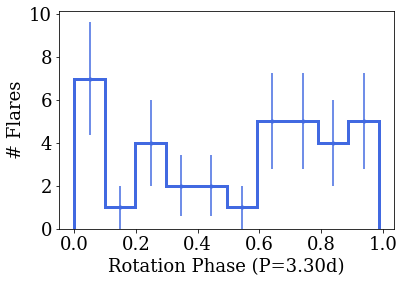

In [26]:
yh, xh, _ = plt.hist(np.mod(fbeye['t_start'], p_rot)/p_rot, bins=10, histtype='step', lw=3, color='RoyalBlue')

plt.errorbar((xh[1:]+xh[0:-1])/2., yh, yerr=np.abs(funcs.poisson_conf_interval(yh)-yh), 
             marker='.', ls='none', color='RoyalBlue')

plt.xlabel('Rotation Phase (P=3.30d)')
plt.ylabel('# Flares')

plt.savefig('Nflares_rot.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

(2979.8, 2980)

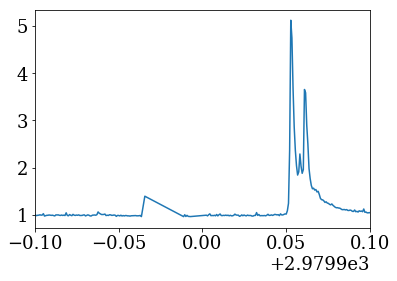

In [27]:
# try the data reduction from John Gizis, where I did another FBEYE run on it
file2 = 'trappist_r3_short_cleaned.txt'
df2 = pd.read_table(file2, header=None, delim_whitespace=True, names=('time','flux','x','y'))

names = ('Event_ID','Start_INDX','Stop_INDX','t_peak','t_start','t_stop','t_rise','t_decay',
         'Flux_peak','Equiv_Dur','S/N','CPLX_flg','MLTPK_flg','MLTPK_num','t_MLTPK','L_mltpk',
         'MLTPK_INDX','quies','x')
fbeye2 = pd.read_table(file2 + '.fbeye', delim_whitespace=True, header=None, names = names, comment='#')

plt.plot(df2['time'], df2['flux']/np.median(df2['flux']))
plt.xlim(2979.8,2980)

/Users/james/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/james/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


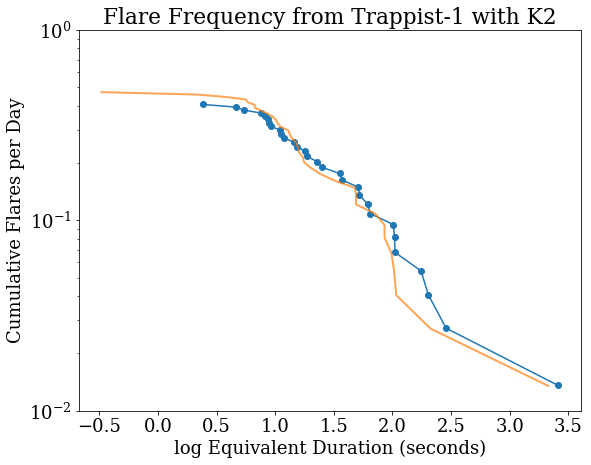

In [28]:
t = df2['time'].values
flux = df2['flux'].values / np.median(df2['flux']) - 1.

ED2 = np.zeros(len(fbeye2)-1)

# the first entry is null, skip it
for k in range(1,len(fbeye2)):
    xfl = np.where((t >= fbeye2['t_start'].values[k]) & (t <= fbeye2['t_stop'].values[k]))

    c1 = np.where((t <= fbeye2['t_start'].values[k]-5.0/24./60.) & (t >= fbeye2['t_start'].values[k]-0.1))
    c2 = np.where((t >= fbeye2['t_stop'].values[k]+10.0/24./60.) & (t <= fbeye2['t_stop'].values[k]-0.1))
    
    slope = (np.median(flux[c1])-np.median(flux[c2]))/(np.median(t[c1])-np.median(t[c2]))
    inter = np.median(flux[c1]) - slope*np.median(t[c1])
    fit = [inter,slope]
    
    ED2[k-1] = np.trapz(flux[xfl], t[xfl]*86400.)

###
exptime = 1. / 24./60. # 1 min, in units of days
totdur = float(len(t)) * exptime

ss = np.argsort(ED2)[::-1]

ffd_x2 = np.log10(ED2[ss])
ffd_y2 = (np.arange(len(ffd_x2)) + 1) / totdur


plt.figure(figsize=(9,7))
plt.plot(ffd_x2, ffd_y2, 'o-')
plt.plot(ffd_x, ffd_y, lw=2, alpha=0.7)
plt.yscale('log')
plt.ylim(1e-2,1e0)
plt.xlabel('log Equivalent Duration (seconds)')
plt.ylabel('Cumulative Flares per Day')

plt.title('Flare Frequency from Trappist-1 with K2')
# plt.text(0.5, 1.2e-2, '@jradavenport', fontsize=12)
# plt.text(2.5, 8e-1, 'N=35 events', fontsize=12)

# plt.savefig('trappist_flares_ED_Gizis.png')

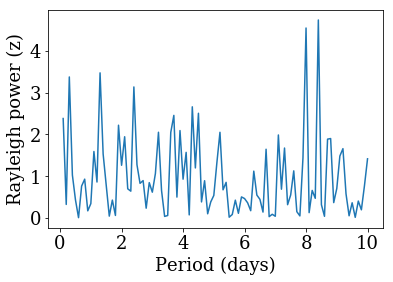

In [29]:
# look for periodicity w/ Rayleigh test
ps = rayleigh.RayleighPowerSpectrum(fbeye['t_peak'].values, minper=0.1, maxper=10, nper=100)

plt.figure()
plt.plot(np.linspace(0.1, 10, 100), ps)
plt.xlabel('Period (days)')
plt.ylabel('Rayleigh power (z)')
plt.show()

In [30]:
# Check out the EVEREST light curves...
# short cadence:
eSLC = pd.read_table('sc_whitened.dat', names=('cnum', 'time', 'flux'), skiprows=1, delim_whitespace=True)

(50, 60)

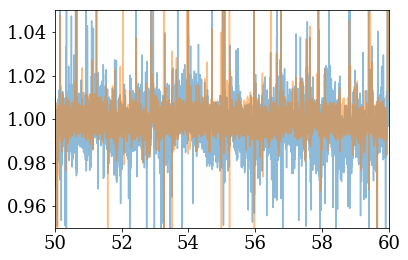

In [31]:
eok = np.where((eSLC['flux'].values > .9) & (eSLC['flux'].values < 1.2))
fnorm = (fraw - np.nanmedian(fraw[x])) / np.nanmedian(fraw[x])

plt.plot(time[x] + 2454833 - 2457700, fnorm[x]+1, alpha=0.5)
plt.plot(eSLC['time'].values[eok], eSLC['flux'].values[eok], alpha=0.5)

plt.ylim(.95,1.05)
plt.xlim(50,60)

# ANSWER: no real sign of rotation. not much use for me here

In [32]:
# now EVEREST Long Cadence:
eLLC_file = 'trappist_everest_luger.fits'

ef = pyfits.open(eLLC_file)
eLLC = ef[1].data
eLLC.columns

ColDefs(
    name = 'CADN'; format = 'D'
    name = 'FLUX'; format = 'D'; unit = 'e-/s'
    name = 'FRAW'; format = 'D'; unit = 'e-/s'
    name = 'FRAW_ERR'; format = 'D'; unit = 'e-/s'
    name = 'QUALITY'; format = 'J'
    name = 'TIME'; format = 'D'; unit = 'BJD - 2454833'
    name = 'BKG'; format = 'D'; unit = 'e-/s'
)

In [33]:
eLLC['QUALITY']

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

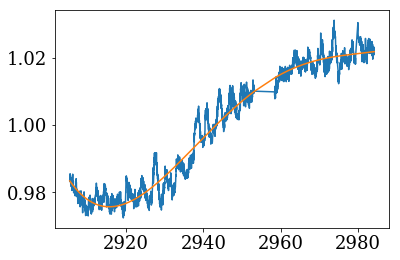

In [34]:
flux_LLC = eLLC['FLUX'] / np.nanmedian(eLLC['FLUX'] )
time_LLC = eLLC['TIME']
eok = np.where((eLLC['QUALITY'] == 0) & (flux_LLC > 0.95)& (flux_LLC < 1.2))
               
pp = np.polyfit(time_LLC[eok], flux_LLC[eok], 4)
fit = np.polyval(pp, time_LLC[eok])

plt.plot(time_LLC[eok], flux_LLC[eok])
plt.plot(time_LLC[eok], fit)

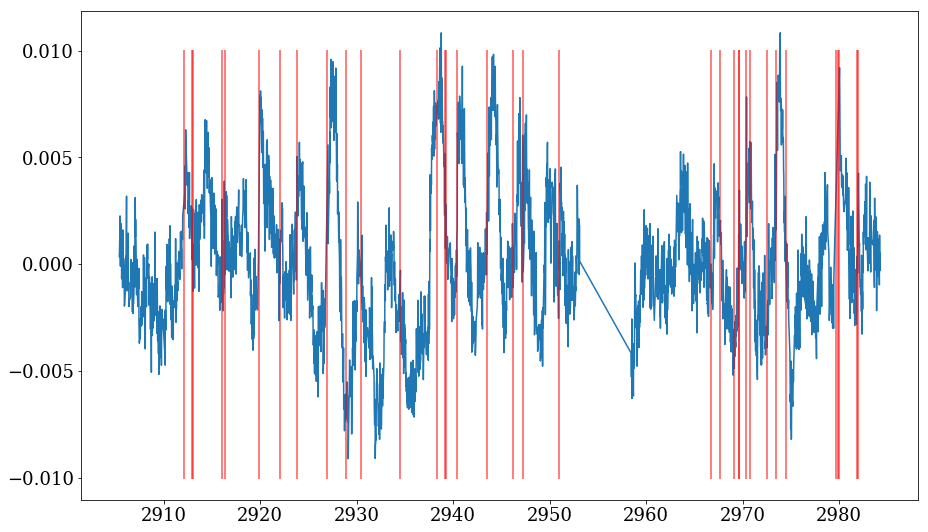

In [35]:
plt.figure(figsize=(15,9))

plt.plot(time_LLC[eok], flux_LLC[eok] - fit)

for k in range(1,len(fbeye)):
    plt.plot([fbeye['t_peak'][k], fbeye['t_peak'][k]], [-0.01, 0.01], color='r', alpha=0.5, lw=2)

#  + 2454833 - 2457700

In [36]:
# try a phase-plot...

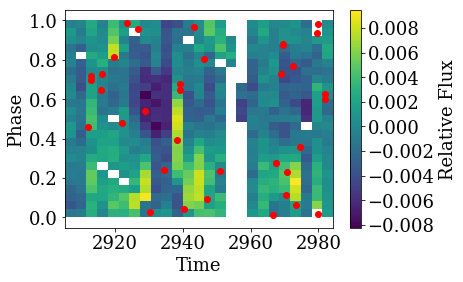

In [45]:
bin2d, xx, yy, _ = binned_statistic_2d(time_LLC[eok], np.mod(time_LLC[eok], p_rot)/p_rot, flux_LLC[eok] - fit,
                                       statistic='median', bins=[25,25])

plt.figure()

plt.imshow(bin2d.T, interpolation='nearest', aspect='auto', origin='lower',
           extent=(xx.min(),xx.max(),yy.min(),yy.max()),
           cmap=plt.cm.viridis)

plt.xlabel('Time')
plt.ylabel('Phase')
# plt.xlim((0,1.7))
# plt.ylim(-1,2)
cb = plt.colorbar()
cb.set_label('Relative Flux')

plt.scatter(fbeye['t_peak'][1:], np.mod(fbeye['t_peak'][1:], p_rot)/p_rot, c='r')



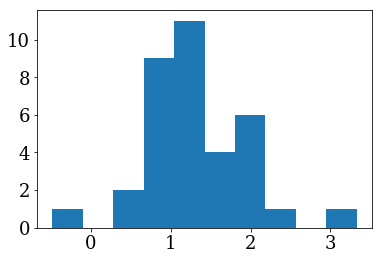

In [58]:
_ = plt.hist(np.log10(ED))

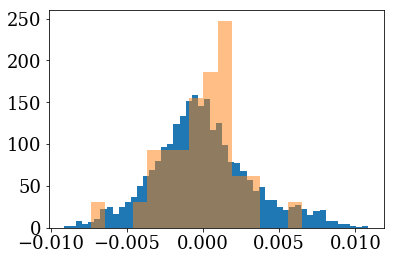

In [56]:
fluxmodel = flux_LLC[eok] - fit

F_near = np.zeros_like(ED)
for k in range(len(ED)):
    F_near[k] = fluxmodel[np.argmax(np.where((time_LLC[eok] < (fbeye['t_peak'][k+1] - 0.0416)))[0])]

_ = plt.hist(fluxmodel, bins=50, normed=True)
_ = plt.hist(F_near, bins=15, alpha=0.5, normed=True)

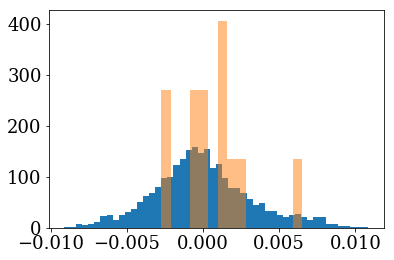

In [72]:

# Try for the BIG flares


EDbig_x = np.where((np.log10(ED) > 1.5) )[0]

F_nearbig = np.zeros(len(EDbig_x))
for k in range(len(EDbig_x)):
    F_nearbig[k] = fluxmodel[np.argmax(np.where((time_LLC[eok] < (fbeye['t_peak'].values[1:][EDbig_x[k]] - 0.0416)))[0])]

_ = plt.hist(fluxmodel, bins=50, normed=True)
_ = plt.hist(F_nearbig, bins=15, alpha=0.5, normed=True)

In [70]:
fbeye['t_peak'].values[EDbig_x]

array([    0.        ,  2916.29468014,  2923.75702004,  2930.48648634,
        2934.49896474,  2939.23411164,  2940.44241854,  2969.61001544,
        2972.54087544,  2974.47185104,  2979.68650704,  2981.87494614])